In [1]:
# import modules
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import time


In [2]:
R = 100
c = 1

In [3]:
# define the exploration function

def softmax(av, epsilon):
    av_ep = av / (epsilon*5)
    valid = False
    while (not valid):
        if (np.max(np.exp(av_ep)) > 2**100):
            av_ep = av_ep/10
        else:
            valid = True
        
    softm = ( np.exp(av_ep) / np.sum( np.exp(av_ep)))
    return softm

In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [5]:
# Miner class: miner features and tasks
# h_i: miner i action
# h_i/sum(h_j) : miner i state
num_actions = int(R/c)
num_hash = int(R/c)
num_pr = 100 

class Miner():
    def __init__(self, u_id , c , epsilon): #epsilon = 0.99997
        self.id = u_id
        self.cost = c
        self.epsilon = epsilon
        self.q_table = np.zeros((num_actions , num_pr+1 , num_hash+1)) # first: number of actions, second: previous pr, third: pre hash
        self.action = 0
        
    def step(self , n , old_pr , old_hash): # n: number of iteration
        epsilon = self.epsilon ** n 
        '''
        p=softmax(self.q_table[: , old_pr , old_hash] , epsilon )
        action = np.random.choice( list(range(0 , num_actions)) , p=p)
        '''
        if random.random() < epsilon:
            action = random.randint(0 , num_actions - 1)
        else:
            action = np.argmax(self.q_table[: , old_pr , old_hash ])
        
        
        self.action = action
        return self.action
        
    def update_qtable(self , new_pr , new_hash , old_pr , old_hash , reward , alpha , gamma):  # old state: old_pr, old_hash| new state: new_pr , new_hash
        max_q = np.max(self.q_table[: , new_pr , new_hash])
        self.q_table[self.action , old_pr , old_hash] = (1-alpha)*self.q_table[self.action , old_pr , old_hash] + alpha*(reward + gamma*max_q)
        

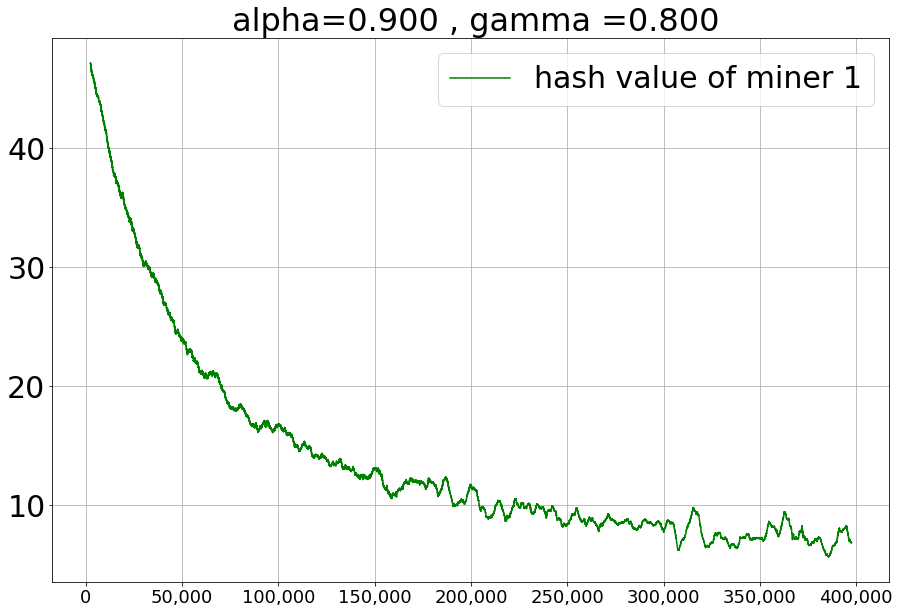

<Figure size 1080x720 with 0 Axes>

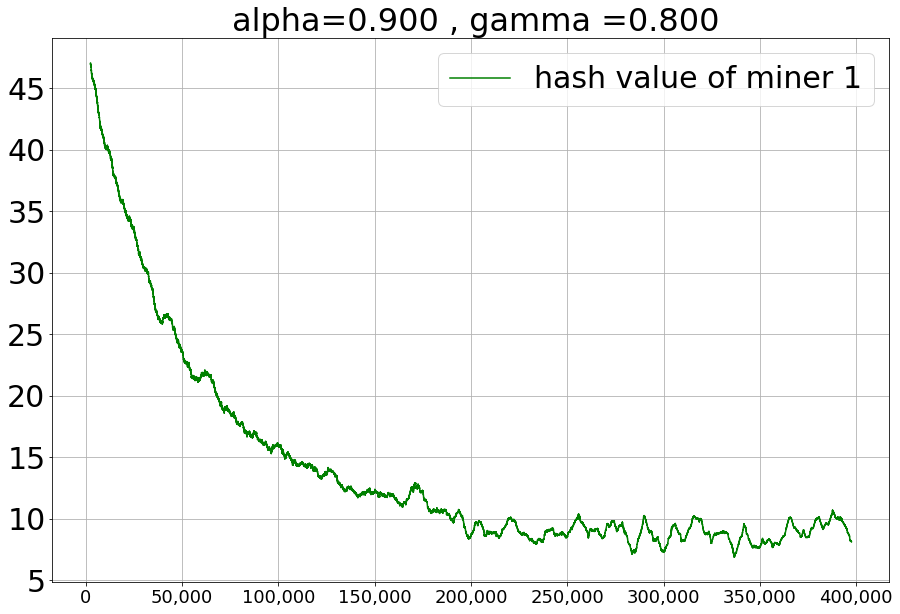

<Figure size 1080x720 with 0 Axes>

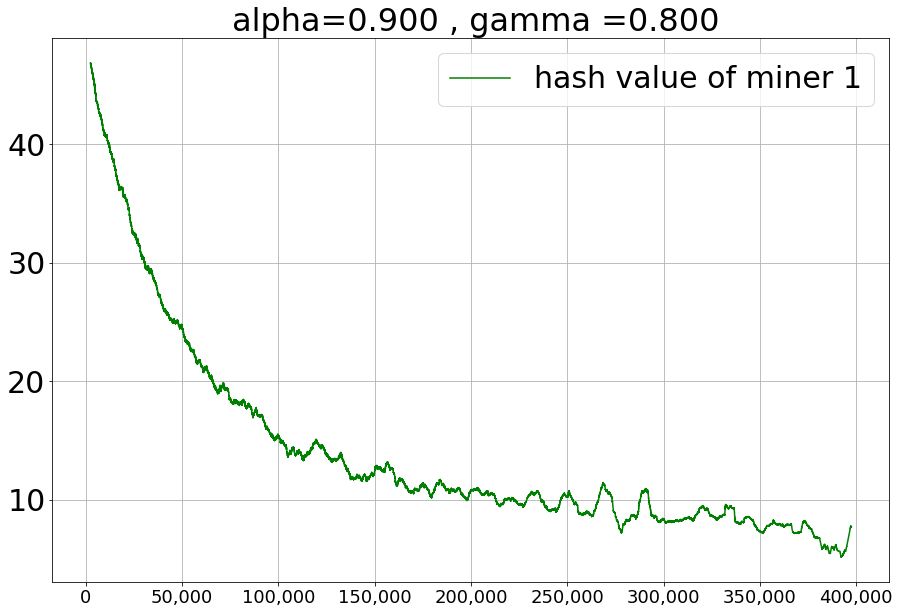

<Figure size 1080x720 with 0 Axes>

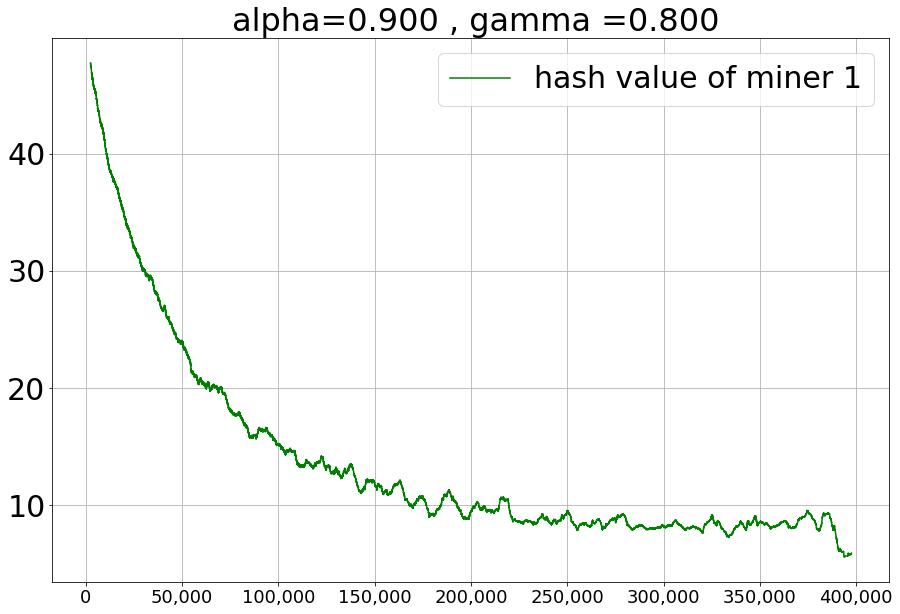

<Figure size 1080x720 with 0 Axes>

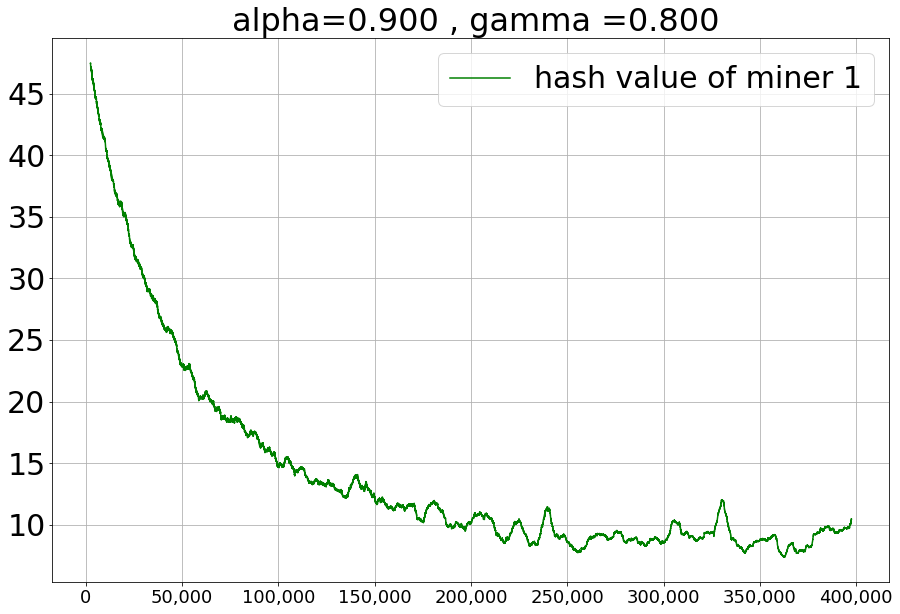

<Figure size 1080x720 with 0 Axes>

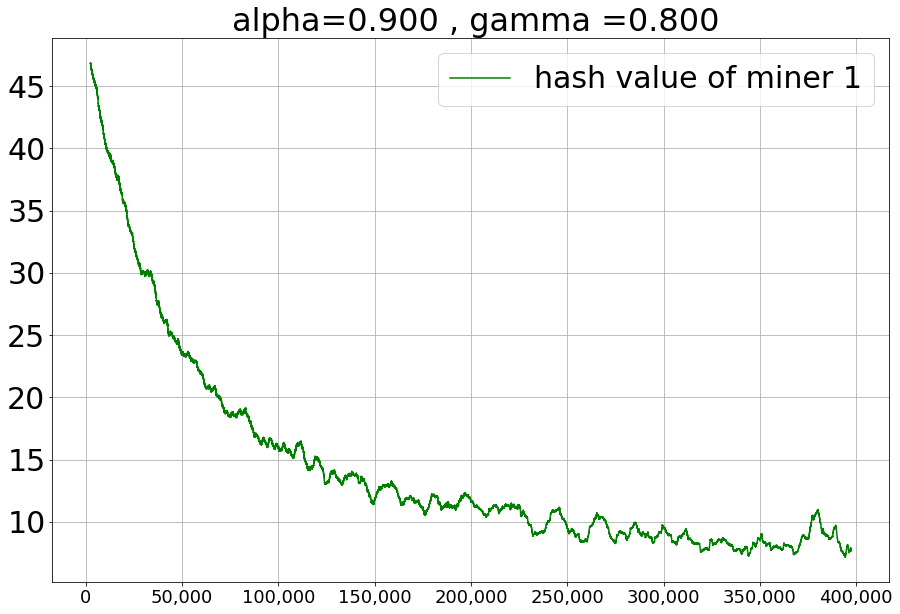

<Figure size 1080x720 with 0 Axes>

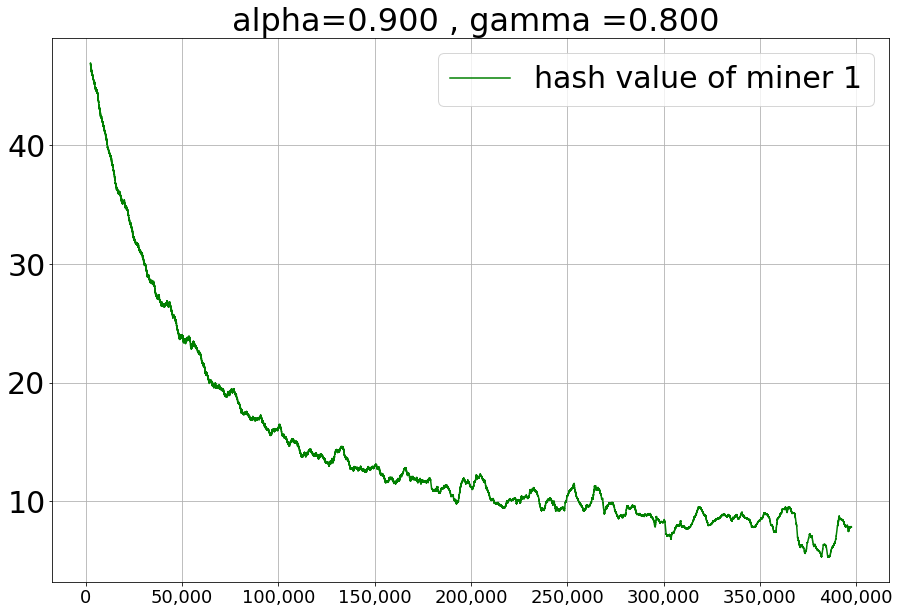

<Figure size 1080x720 with 0 Axes>

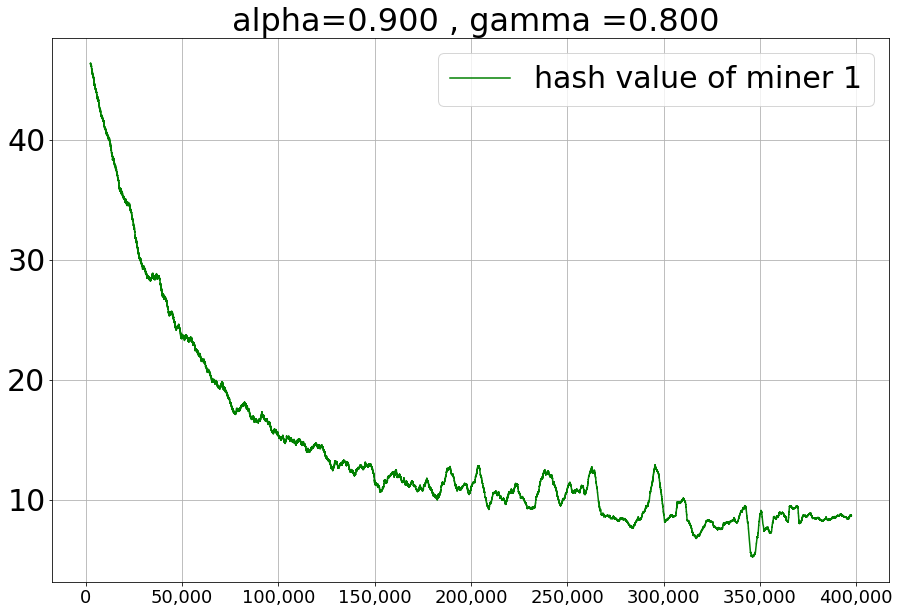

<Figure size 1080x720 with 0 Axes>

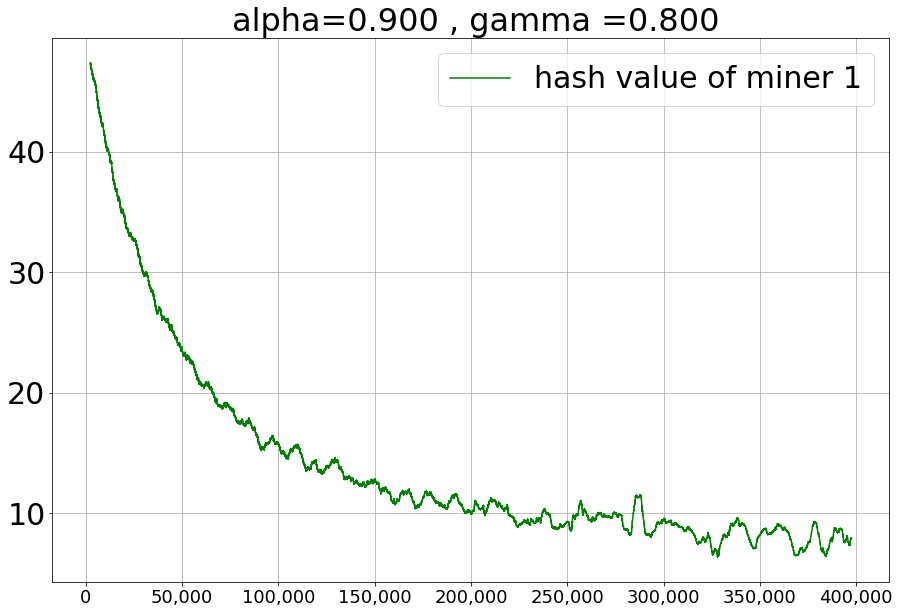

<Figure size 1080x720 with 0 Axes>

In [23]:
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
# create the market
n_miner = 5
n_iter = 400000
ALPHA = [0.9 , 0.9 , 0.9]
GAMMA = [ 0.8 , 0.8  , 0.8]
#gamma = 0.1
old_pr = [0]*n_miner
old_hash = [0]*n_miner
EPS =  0.99998

# create list of all possible params
params=[] # alpha , gamma
for i in range(0 , len(ALPHA)):
    for j in range(0 , len(GAMMA)):
        params.append([ALPHA[i] , GAMMA[j]])

# parametrization for loop
for x in range(0 , len(params)):
    Miners=[]
    # create the miners
    for i in range(n_miner):
        Miners.append(Miner(i , c , EPS))
    # create a for loop containing the episodes
    H=[]
    REWARDS = []
    alpha = params[x][0]
    gamma = params[x][1]
    for i in range(n_iter):
        #print(i)
        hashes = []
        # get miners actions
        for m in range(n_miner):
            hashes.append(Miners[m].step(i , old_pr[m] , old_hash[m]))
        # get states; probabilities of winning 
        if max(hashes)==0:
            prs = [0]*n_miner
        else:
            prs = [round(hashes[k]/sum(hashes) , 2) for k in range(n_miner)] # 0<prs[i]<1

        H.append(hashes)
        probs = [int(prs[k]*100) for k in range(n_miner)] # 0<probs[i]<100 
        # get rewards as pr(win)*R - cost*hash
        rewards = [prs[l]*R-c*hashes[l] for l in range(n_miner)]
        REWARDS.append(rewards)

        # update q-tables
        for j in range(n_miner):
            Miners[j].update_qtable(probs[j] , hashes[j] , old_pr[j] , old_hash[j] , rewards[j] , alpha , gamma)
        # set old states as new states
        old_pr = probs
        old_hash = hashes
    h1 = [H[i][0] for i in range(n_iter)]
    hashes_1 = moving_average(h1 , 5000)
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = [15, 10]
    
    x_axes = moving_average( list(range(0 , n_iter )) , 5000)
    plt.plot(x_axes , hashes_1 , 'g' , label = 'hash value of miner 1')
    plt.title(" alpha=%1.3f"%alpha + " , gamma =%1.3f" %gamma, fontsize=32)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=18)
    plt.legend()
    plt.grid()    
    leg = ax.legend(prop={"size":30})
    plt.savefig('pparams_'+str(x)+'.jpg')
    plt.show()
    plt.clf()